In [1]:
import PIL.Image as PILImage

from laion_code.dalle2_laion import ModelLoadConfig, DalleModelManager
from laion_code.InferenceScript import InferenceScript

import utils
import numpy as np
import torchvision.transforms as transforms

####  model loading<br>
WARNING - it requires up to 20gb RAM

In [2]:
model_config = ModelLoadConfig.from_json_path("models/model_loading_config.json")
model_manager = DalleModelManager(model_config)

models/prior.pth already exists. Skipping download. No checksum found so if you think this file should be re-downloaded, delete it and try again.


#### restoration inference 

In [3]:
class ExampleInference(InferenceScript):
    def run(
            self, text: str, cond_img=None, text_cond_scale=1,
            start_at_unet_number=2, start_diffusion_step=0, lowres_noise_level=1000, base_noise_level=1
        
        ) -> PILImage.Image:
        """
        Takes a string with description of image, lowres upscaled conditional image and tries to restore details. Start diffusion step is the main parameter and diffusion steps are in reverse (so start at x and denoise to 0).
        """
        text = [text]
        cond_img = [cond_img]
        image_embedding_map = self._sample_prior(text, cond_scale=text_cond_scale)
        image_embedding = image_embedding_map[0][0] 
        image_embedding = image_embedding.unsqueeze(0)
        image_map = self._sample_decoder(
            cond_images=cond_img, text=text, image_embed=image_embedding, start_at_unet_number=start_at_unet_number,
            start_diffusion_step=start_diffusion_step, base_noise_level=base_noise_level, lowres_noise_level=lowres_noise_level
        )
        return image_map[0][0]

inference = ExampleInference(model_manager)

sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

score: 33.839


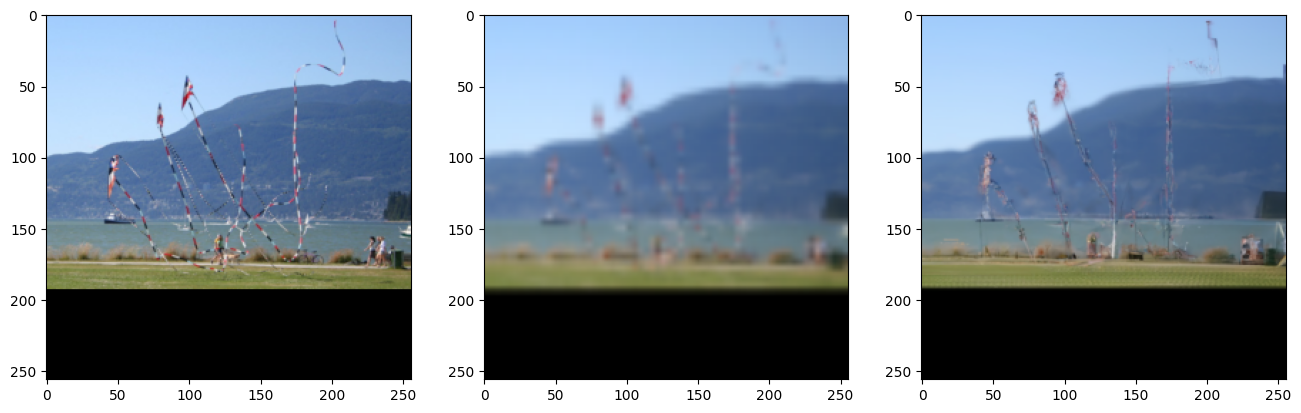

In [22]:
# example
import matplotlib.pyplot as plt

i = 5
test_img = PILImage.open(f'test/imgs/{i}.jpg')
with open(f'test/texts/{i}.txt', 'r') as f:
    test_txt = [
        line for line in f.read().split('\n') if len(line)
    ]

target = utils.scale_image(test_img, 256)
compressed_img = utils.scale_image(target, 64)
scaled_compressed_img = utils.scale_image(compressed_img, 256)
compressed_tensor = transforms.PILToTensor()(compressed_img).unsqueeze(0).to('cuda') / 255

uncompressed_img = inference.run(
    f"{test_txt[0]}", 
    compressed_tensor,
    start_diffusion_step=1000,
    base_noise_level=0.7, text_cond_scale=16
)

f, ax = plt.subplots(1, 3, figsize=(16, 6))
ax[0].imshow(np.array(target))
ax[1].imshow(np.array(scaled_compressed_img))
ax[2].imshow(np.array(uncompressed_img))
print(f'score: {utils.calc_rgb_psnr(np.array(uncompressed_img), np.array(target)):.3f}')

#### evaluation

In [46]:
score_sum = 0
n_examples = 5

for i in range(n_examples):
    i += 1
    test_img = PILImage.open(f'test/imgs/{i}.jpg')
    with open(f'test/texts/{i}.txt', 'r') as f:
        test_txt = [
            line for line in f.read().split('\n') if len(line)
        ]
    target = utils.scale_image(test_img, 256)
    compressed_img = utils.scale_image(target, 64)
    compressed_tensor = transforms.PILToTensor()(compressed_img).unsqueeze(0).to('cuda') / 255

    results = [
        inference.run(
        f"{test_txt[j]}, 4k photo",
        compressed_tensor,
        start_diffusion_step=1000,
        base_noise_level=0.8, text_cond_scale=12
        ) for j in range(2)
    ]
    text_idx, curr_score = max(
        [(j, utils.calc_rgb_psnr(np.array(result), np.array(target))) for j, result in enumerate(results)],
        key=lambda t: t[1]
    )
    score_sum += curr_score
    print(f'{i}:', test_txt[text_idx], curr_score)

print(f'average RGB-PSNR is {score_sum / n_examples:.3f}')

sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

1: a very bright teddy bear posed over a board. 34.0011668975687


sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

2: a train going down the tracks by a country road. 31.38659567950582


sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

3: a young lady laughing in a kitchen with a cake in front of her on the counter. 32.182000613976335


sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

4: a showroom featuring a black and white truck. 32.483060662218634


sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

5: a bunch of kites that are fly in by a small lake. 33.9611454242635
average RGB-PSNR is 32.803
